# RNN (Recurrent Neural Network)(순환 신경망)
 - 과거 기억도 현재 기억에 영향을 주는 신경망
 - LSTM ,GRU등이 속함

# 데이터 전처리


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import sklearn as sns

In [ ]:
batch_size = 100

In [ ]:
path  = "/content/drive/MyDrive/TensorFlow/dataset/stock_daily.csv"

df = pd.read_csv(path,header=1)

In [ ]:
df

,# Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012
...,...,...,...,...,...
727,599.992707,604.832763,562.192568,147100,567.002574
728,558.712504,568.452595,558.712504,7900,567.162558
729,566.892592,567.002574,556.932537,10800,556.972503
730,561.202549,566.432590,558.672539,41200,559.992565


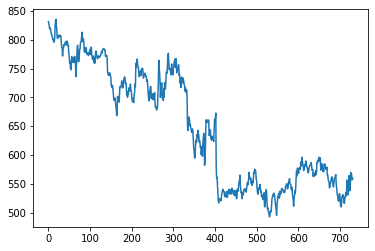

In [ ]:
df['Close'].plot()

In [ ]:
dataset=df.copy()
ori_y=dataset.pop("Close")
ori_x=dataset.copy()
# x_dim = 4 (속성 개수 )
# 시계열 데이터이므로  shuffle= False
train_x ,test_x ,train_y,test_y = train_test_split(ori_x ,ori_y , test_size = 0.2 , shuffle= False)
train_x ,val_x ,train_y,val_y = train_test_split(train_x ,train_y , test_size = 0.1 ,  shuffle=False)

In [ ]:
dataset_des = dataset.describe()
dataset_des = dataset_des.T

In [ ]:
dataset_des

,count,mean,std,min,25%,50%,75%,max
# Open,732.0,6.481047e+02,101.098916,494.652237,5.467406e+02,6.383150e+02,7.447850e+02,8.378100e+02
High,732.0,6.531636e+02,101.599889,495.978230,5.508375e+02,6.432250e+02,7.490475e+02,8.419500e+02
Low,732.0,6.422747e+02,100.844019,487.562205,5.415900e+02,6.270900e+02,7.370438e+02,8.283500e+02
Volume,732.0,1.909881e+06,999296.891561,7900.000000,1.318450e+06,1.667350e+06,2.145475e+06,1.116490e+07


In [ ]:
# min_max 정규화
def min_max_norm(x):
  return ((x - dataset_des['min'])/(dataset_des['max'] - dataset_des['min']))
# 기본 정규화
def standarc_norm(x):
  return (x - dataset_des['mean']) / dataset_des['std']

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator 참고
# tf.keras.preprocessing.sequence.TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)
# tf.keras.preprocessing.sequence.TimeseriesGenerator 에 넣기 위해 데이터를 2D로 변환 , 변환하는 과정에서 정규화 실시 

# min_max 정규화
min_max_norm_train_x = min_max_norm(train_x)
min_max_norm_test_x = min_max_norm(test_x)
min_max_norm_val_x = min_max_norm(val_x)
# list로 변환 (2D)
min_max_norm_train_x = min_max_norm_train_x.values.tolist()
min_max_norm_test_x = min_max_norm_test_x.values.tolist()
min_max_norm_val_x = min_max_norm_val_x.values.tolist()

In [ ]:
data_gen_train = \
tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_train_x ,
                                                    train_y.values.tolist() ,
                                                    length = 4 , 
                                                    batch_size = batch_size)
data_gen_test = \
tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_test_x ,
                                                    test_y.values.tolist() ,
                                                    length = 4 , 
                                                    batch_size = batch_size)
data_gen_val = \
tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_val_x ,
                                                    val_y.values.tolist() ,
                                                    length = 4 , 
                                                    batch_size = batch_size)

In [ ]:
# pytorch 와 유사한 방법인 Subclassing API 로 구현

class RnnModel(Model):
  def __init__(self , rnn_activation_function):
    # 부모 클래스의 생성자 실행
    super(RnnModel , self).__init__()
    # SimpleRNN(units)
    self.rnn_layer = layers.SimpleRNN(128 , activation = rnn_activation_function)
    self.dense_list = [layers.Dense(int(128/ 2**i ),activation = 'relu') if i != 4 else layers.Dense(1,activation = None)  for i in range(1,5) ]

    

# Functional 모델 처럼 정의
  def call(self , x):
    x = self.rnn_layer(x)
    for dense in self.dense_list:
      x = dense(x)
    return x

# 모델 요약을 출력
  def summary(self):
    inputs = layers.Input((5,4))
    Model(inputs,self.call(inputs)).summary()

rnn_model_tanh  = RnnModel('tanh')
rnn_model_relu  = RnnModel('relu')
rnn_model_tanh.build(input_shape =  (None,5,4))
rnn_model_relu.build(input_shape =  (None,5,4))


# 모델 요약
rnn_model_tanh.summary()
rnn_model_relu.summary()



# 손실 함수 mse
loss_function=tf.keras.losses.mean_squared_error

#정규화기(최적화 알고리즘) Adam
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

# 평가 지표 mae
metrics=tf.keras.metrics.mean_absolute_error


rnn_model_tanh.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=[metrics])


rnn_model_relu.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=[metrics])

    


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 4)]            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 128)               17024     
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 27,905
Trainable params: 27,905
Non-trainable

In [ ]:
# 모델 훈련
history_tanh = rnn_model_tanh.fit(
      data_gen_train,
      validation_data=data_gen_val,
      steps_per_epoch=len(train_x)/batch_size,
      epochs=100,
      validation_freq = 1
)
# 모델 훈련
history_relu = rnn_model_relu.fit(
      data_gen_train,
      validation_data=data_gen_val,
      steps_per_epoch=len(train_x)/batch_size,
      epochs=100,
      validation_freq = 1
)

Epoch 1/100
5/5 [==============================] - 1s 72ms/step - loss: 477165.6250 - mean_absolute_error: 684.3797 - val_loss: 281458.0625 - val_mean_absolute_error: 530.2648
Epoch 2/100
5/5 [==============================] - 0s 16ms/step - loss: 475752.5000 - mean_absolute_error: 683.3875 - val_loss: 280883.8438 - val_mean_absolute_error: 529.7264
Epoch 3/100
5/5 [==============================] - 0s 15ms/step - loss: 473333.5000 - mean_absolute_error: 681.6823 - val_loss: 279258.8438 - val_mean_absolute_error: 528.1974
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 468768.2500 - mean_absolute_error: 678.2891 - val_loss: 275092.8750 - val_mean_absolute_error: 524.2491
Epoch 5/100
5/5 [==============================] - 0s 22ms/step - loss: 461151.8750 - mean_absolute_error: 672.6409 - val_loss: 267446.9688 - val_mean_absolute_error: 516.9078
Epoch 6/100
5/5 [==============================] - 0s 19ms/step - loss: 451552.9688 - mean_absolute_error: 665.3059 - va

In [ ]:
# data_gen_test에서 test x,y 데이터를 가지고 온다.
test_data_x, test_data_y=data_gen_test[0]
# 예상한 값을 test_data_y와 비교해 주시기 위해 평탄화(1차원)해준다.
prediction_tanh_y=rnn_model_tanh.predict(test_data_x).flatten()
prediction_relu_y=rnn_model_relu.predict(test_data_x).flatten()
test_y=test_data_y.flatten()

4/4 [==============================] - 0s 3ms/step


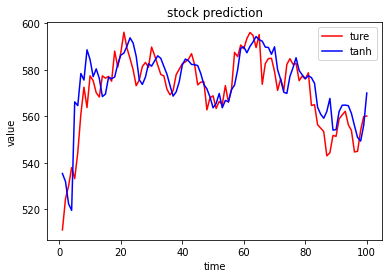

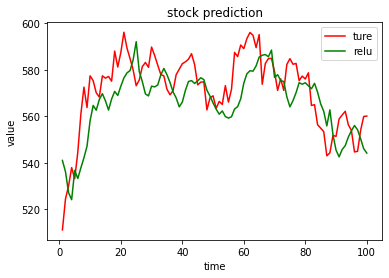

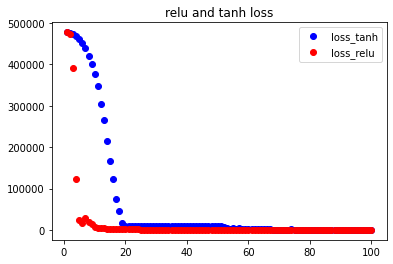

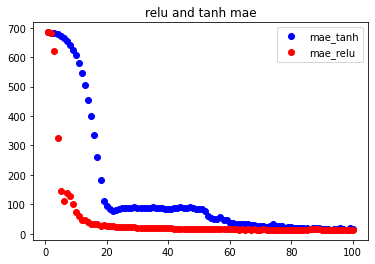

In [ ]:
# plot.으로 나타내기 위해 다음과 같이한다.
time = range(1, len(test_y) + 1)
plt.plot(time, test_y, 'r', label='ture')
plt.plot(time, prediction_tanh_y, 'b', label='tanh')

plt.title('stock prediction')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

plt.plot(time, test_y, 'r', label='ture')
plt.plot(time, prediction_relu_y, 'g', label='relu')

plt.title('stock prediction')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

loss_tanh = history_tanh.history['loss']
loss_relu = history_relu.history['loss']


epochs = range(1, len(loss_tanh) + 1)

plt.plot(epochs, loss_tanh, 'bo', label='loss_tanh')
plt.plot(epochs, loss_relu, 'ro', label='loss_relu')
plt.title('relu and tanh loss')
plt.legend()
plt.show()

mae_tanh = history_tanh.history['mean_absolute_error']
mae_relu = history_relu.history['mean_absolute_error']


plt.plot(epochs, mae_tanh, 'bo', label='mae_tanh')
plt.plot(epochs, mae_relu, 'ro', label='mae_relu')
plt.title('relu and tanh mae')
plt.legend()
plt.show()